In [35]:
# analysis_experiments.py
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from experiment import (
    generate_random_portfolio_instance, 
    classical_optimum, 
    build_ising_coeffs,
    random_qaoa_optimize,
    sample_qaoa_bitstrings,
    bitstring_to_array,
    portfolio_cost
)

PROBLEM 1: Does problem hardness correlate with optimal depth?
=== Problem Hardness vs Optimal Depth Analysis ===\n
Analyzing n=4, B=2
  Depth 1: Success rate = 1.00, Avg energy = -2.5005
  Depth 2: Success rate = 1.00, Avg energy = -2.9024
  Depth 3: Success rate = 1.00, Avg energy = -3.4393
  Depth 4: Success rate = 1.00, Avg energy = -2.8229
Analyzing n=6, B=3
  Depth 1: Success rate = 1.00, Avg energy = -4.2146
  Depth 2: Success rate = 1.00, Avg energy = -3.2275
  Depth 3: Success rate = 1.00, Avg energy = -2.9595
  Depth 4: Success rate = 1.00, Avg energy = -3.2449
Analyzing n=8, B=4
  Depth 1: Success rate = 1.00, Avg energy = -5.5471
  Depth 2: Success rate = 1.00, Avg energy = -3.2725
  Depth 3: Success rate = 0.80, Avg energy = -2.8070
  Depth 4: Success rate = 1.00, Avg energy = 0.3489


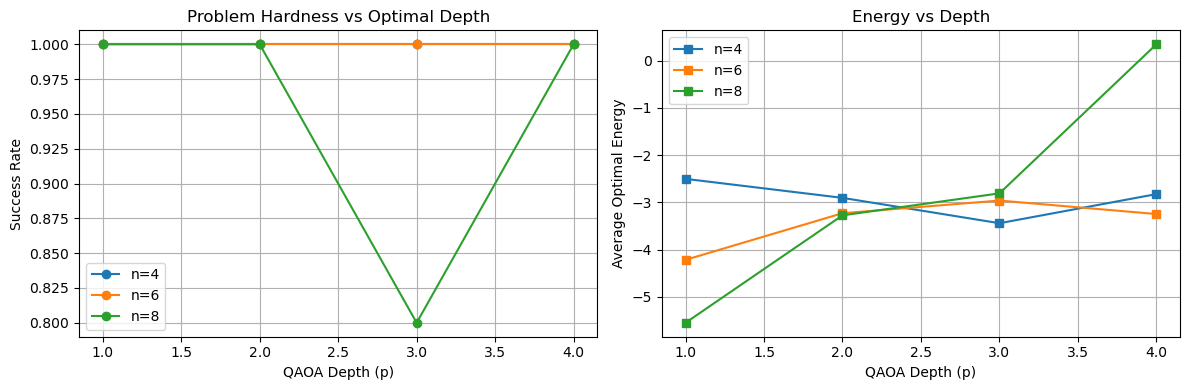

In [21]:
def analyze_problem_hardness_vs_depth():
    """Answer: Does problem hardness correlate with optimal depth?"""
    print("=== Problem Hardness vs Optimal Depth Analysis ===\\n")
    
    # Test different problem sizes and measure performance at various depths
    problem_sizes = [4, 6, 8]
    depths = [1, 2, 3, 4]
    n_trials = 5
    q = 1.0/3.0
    B_values = {4: 2, 6: 3, 8: 4}  # B ≈ n/2
    
    results = {}
    
    for n in problem_sizes:
        B = B_values[n]
        print(f"Analyzing n={n}, B={B}")
        results[n] = {'depths': [], 'success_rates': [], 'optimal_energies': []}
        
        for p in depths:
            success_count = 0
            energies = []
            
            for trial in range(n_trials):
                # Generate problem instance
                mu, sigma = generate_random_portfolio_instance(n, seed=123 + trial)
                
                # Get classical optimum for comparison
                z_opt, F_opt = classical_optimum(mu, sigma, q, B)
                
                # Build Ising coefficients
                W, w, c = build_ising_coeffs(
mu, sigma, q, B, A=5.0, lam=1.0)
                
                # Run QAOA
                try:
                    best_energy, best_gammas, best_betas = random_qaoa_optimize(
                        W, w, p, num_trials=30, c=c, seed=999 + trial
                    )
                    
                    # Sample and check if we find optimal solution
                    counts = sample_qaoa_bitstrings(W, w, best_gammas, best_betas, shots=1000)
                    
                    found_optimal = False
                    for bitstring, cnt in counts.items():
                        z = bitstring_to_array(bitstring, n)
                        if z.sum() == B and np.array_equal(z,
 z_opt):
                            found_optimal = True
                            break
                    
                    if found_optimal:
                        success_count += 1
                    energies.append(best_energy)
                    
                except Exception as e:
                    print(f"Error in n={n}, p={p}, trial={trial}: {e}")
                    energies.append(np.nan)
            
            success_rate = success_count / n_trials
            avg_energy = np.nanmean(energies)
            
            results[n]['depths'].append(p)
            results[n]['success_rates'].append(success_rate)
            results[n]['optimal_energies'].append(avg_energy)
            
            print(f"  Depth {p}: Success rate = {success_rate:.2f}, Avg energy = {avg_energy:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    for n in problem_sizes:
        plt.plot(results[n]['depths'], results[n]['success_rates'], 'o-', label=f'n={n}')
    plt.xlabel('QAOA Depth (p)')
    plt.ylabel('Success Rate')
    plt.title('Problem Hardness vs Optimal Depth')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for n in problem_sizes:
        plt.plot(results[n]['depths'], results[n]['optimal_energies'], 's-', label=f'n={n}')
    plt.xlabel('QAOA Depth (p)')
    plt.ylabel('Average Optimal Energy')
    plt.title('Energy vs Depth')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run Problem Hardness Analysis
print("PROBLEM 1: Does problem hardness correlate with optimal depth?")
hardness_results = analyze_problem_hardness_vs_depth()
print("\n" + "="*60 + "\n")


PROBLEM 2: Which parameter most affects noise sensitivity?
\n=== Noise Sensitivity Analysis ===\n
Testing A_penalty:
  A_penalty=1.0: Success rate=1.00, Energy std=0.3471
  A_penalty=3.0: Success rate=1.00, Energy std=1.6373
  A_penalty=5.0: Success rate=0.80, Energy std=1.9533
  A_penalty=10.0: Success rate=0.90, Energy std=4.0944
Testing lam_scale:
  lam_scale=0.5: Success rate=1.00, Energy std=0.9872
  lam_scale=1.0: Success rate=0.90, Energy std=1.9533
  lam_scale=2.0: Success rate=1.00, Energy std=2.8690
  lam_scale=5.0: Success rate=0.90, Energy std=5.4640
Testing q_risk:
  q_risk=0.1: Success rate=1.00, Energy std=1.8495
  q_risk=0.3: Success rate=1.00, Energy std=1.9424
  q_risk=0.5: Success rate=1.00, Energy std=1.9551
  q_risk=0.7: Success rate=1.00, Energy std=1.8360
  q_risk=0.9: Success rate=1.00, Energy std=1.6352


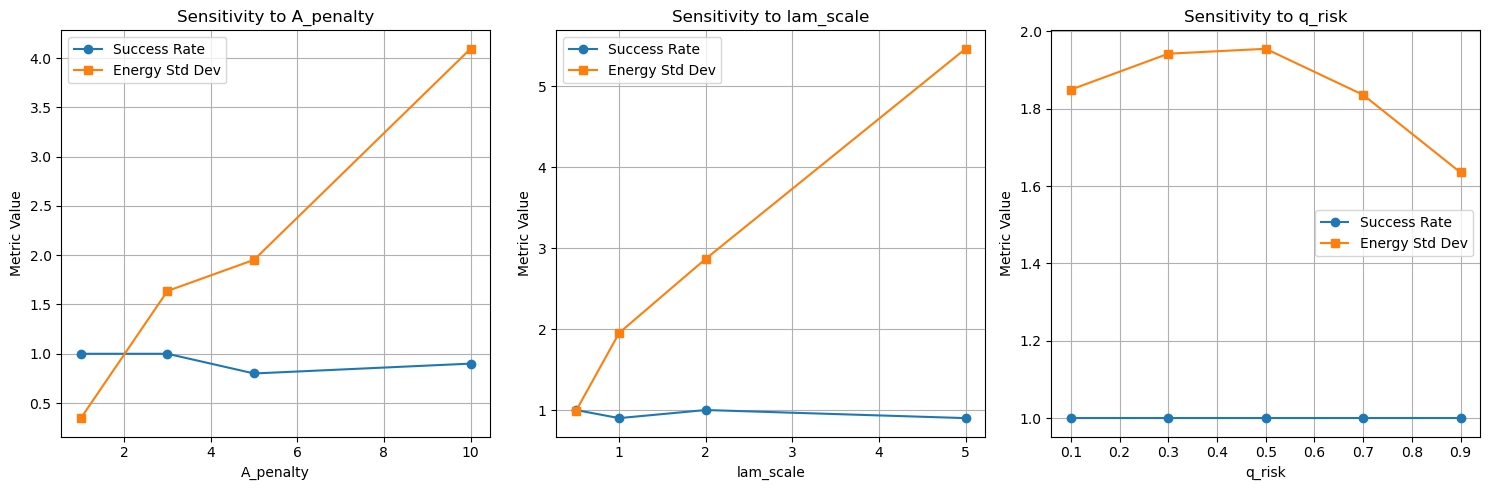

In [23]:
def analyze_noise_sensitivity():
    """Answer: Which parameter most affects noise sensitivity?"""
    print("\\n=== Noise Sensitivity Analysis ===\\n")
    
    n = 6
    B = 3
    q = 1.0/3.0
    p = 2
    
    # Test different parameters
    parameters_to_test = {
        'A_penalty': [1.0, 3.0, 5.0, 10.0],
        'lam_scale': [0.5, 1.0, 2.0, 5.0],
        'q_risk': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    
    mu, sigma = generate_random_portfolio_instance(n, seed=123)
    z_opt, F_opt = classical_optimum(mu, sigma, q, B)
    
    noise_sensitivity_results = {}
    
    for param_name, param_values in parameters_to_test.items():
        print(f"Testing {param_name}:")
        noise_sensitivity_results[param_name] = {'values': [], 'success_rates': [], 'energy_std': []}
        
        for param_value in param_values:

            success_count = 0
            energies = []
            
            for trial in range(10):  # Multiple trials to measure variance
                # Set parameters
                A = param_value if param_name == 'A_penalty' else 5.0
                lam = param_value if param_name == 'lam_scale' else 1.0
                q_test = param_value if param_name == 'q_risk' else q
                
                W, w, c = build_ising_coeffs(mu, sigma, q_test, B, A, lam)
                
                try:
                    best_energy, best_gammas, best_betas = random_qaoa_optimize(
                        W, w, p, num_trials=20, c=c, seed=999 + trial
                    )
                    
                    counts = sample_qaoa_bitstrings(W, w, best_gammas, best_betas, shots=500)
                    
                    # Check success
                    found_optimal = False
                    for bitstring, cnt in counts.items():
                        z = bitstring_to_array(bitstring, n)
                        if z.sum() == B and np.array_equal(z, z_opt):
                            found_optimal = True
                            break
                    
                    if found_optimal:
                        success_count += 1
                    energies.append(best_energy)
                    
                except Exception as e:
                    energies.append(np.nan)
            
            success_rate = success_count / 10

            energy_std = np.nanstd(energies)
            
            noise_sensitivity_results[param_name]['values'].append(param_value)
            noise_sensitivity_results[param_name]['success_rates'].append(success_rate)
            noise_sensitivity_results[param_name]['energy_std'].append(energy_std)
            
            print(f"  {param_name}={param_value}: Success rate={success_rate:.2f}, Energy std={energy_std:.4f}")
    
    # Plot noise sensitivity
    plt.figure(figsize=(15, 5))
    
    for i, (param_name, data) in enumerate(noise_sensitivity_results.items()):
        plt.subplot(1, 3, i+1)
        plt.plot(data['values'], data['success_rates'], 'o-', label='Success Rate')
        plt.plot(data['values'], data['energy_std'], 's-', label='Energy Std Dev')
        plt.xlabel(param_name)
        plt.ylabel('Metric Value')
        plt.title(f'Sensitivity to {param_name}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    
    return noise_sensitivity_results

# Run Noise Sensitivity Analysis
print("PROBLEM 2: Which parameter most affects noise sensitivity?")
sensitivity_results = analyze_noise_sensitivity()
print("\n" + "="*60 + "\n")


PROBLEM 3: Is there a universal optimal depth scaling rule?
\n=== Depth Scaling Analysis ===\n
Analyzing depth scaling for n=4
  Depth 1: Avg energy = -2.5486, Improvement ratio = 0.0000
  Depth 2: Avg energy = -3.2966, Improvement ratio = 0.2935
  Depth 3: Avg energy = -4.3843, Improvement ratio = 0.3299
  Depth 4: Avg energy = -3.2349, Improvement ratio = -0.2622
  Depth 5: Avg energy = -3.7269, Improvement ratio = 0.1521
  Depth 6: Avg energy = -2.6566, Improvement ratio = -0.2872
Analyzing depth scaling for n=6
  Depth 1: Avg energy = -4.7664, Improvement ratio = 0.0000
  Depth 2: Avg energy = -3.9866, Improvement ratio = -0.1636
  Depth 3: Avg energy = -2.9155, Improvement ratio = -0.2687
  Depth 4: Avg energy = -2.1794, Improvement ratio = -0.2525
  Depth 5: Avg energy = -2.2371, Improvement ratio = 0.0265
  Depth 6: Avg energy = 0.3585, Improvement ratio = -1.1602
Analyzing depth scaling for n=8
  Depth 1: Avg energy = -6.8644, Improvement ratio = 0.0000
  Depth 2: Avg energy = 

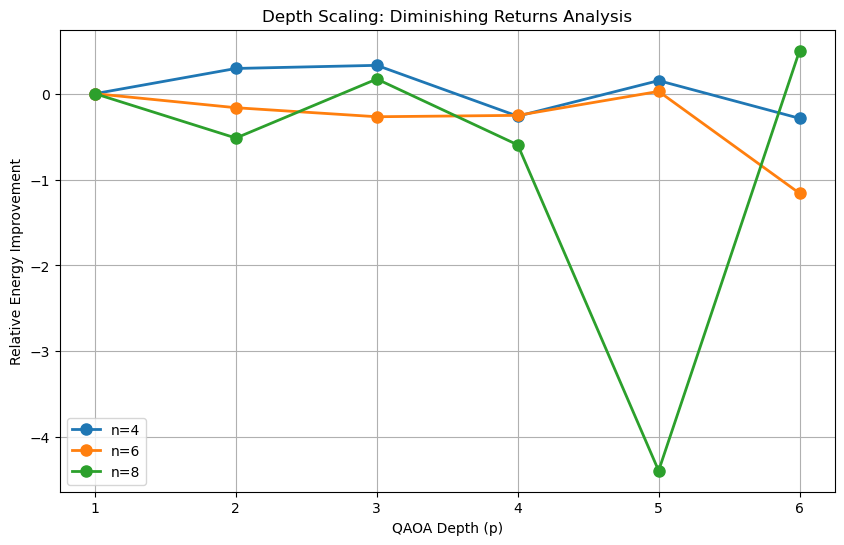

In [25]:
def analyze_depth_scaling():
    """Answer: Is there a universal optimal depth scaling rule?"""
    print("\\n=== Depth Scaling Analysis ===\\n")
    
    problem_sizes = [4, 6, 8]
    max_depth = 6
    q = 1.0/3.0
    n_trials = 3
    
    scaling_results = {}
    
    for n in problem_sizes:
        B = n // 2
        print(f"Analyzing depth scaling for n={n}")
        scaling_results[n] = {'depths': [], 'improvement_ratios': []}
        
        mu, sigma = generate_random_portfolio_instance(n, seed=123)
        z_opt, F_opt = classical_optimum(mu, sigma, q, B)
        W, w, c = build_ising_coeffs(mu, sigma, q, B, A=5.0, lam=1.0)
        
        prev_energy = None
        
        for p in range(1, max_depth + 1):
            energies = []
            
            for trial in range(n_trials):
                try:
                    best_energy, _, _ = random_qaoa_optimize(
                        W, w, p, num_trials=20, c=c, seed=999 + trial
                    )
                    energies.append(best_energy)
                except:
                    energies.append(np.nan)
            
            avg_energy = np.nanmean(energies)
            
            if prev_energy is not None:
                improvement = prev_energy - avg_energy  # Lower energy is better
                improvement_ratio = improvement / abs(prev_energy) if prev_energy != 0 else 0
            else:
                improvement_ratio = 0
            
            scaling_results[n]['depths'].append(p)
            scaling_results[n]['improvement_ratios'].append(improvement_ratio)
            prev_energy = avg_energy
            
            print(f"  Depth {p}: Avg energy = {avg_energy:.4f}, Improvement ratio = {improvement_ratio:.4f}")
    
    # Analyze scaling behavior
    plt.figure(figsize=(10, 6))
    
    for n in problem_sizes:
        depths = scaling_results[n]['depths']
        improvements = scaling_results[n]['improvement_ratios']
        plt.plot(depths, improvements, 'o-', label=f'n={n}', linewidth=2, markersize=8)
    
    plt.xlabel('QAOA Depth (p)')
    plt.ylabel('Relative Energy Improvement')
    plt.title('Depth Scaling: Diminishing Returns Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return scaling_results

# Run Depth Scaling Analysis
print("PROBLEM 3: Is there a universal optimal depth scaling rule?")
scaling_results = analyze_depth_scaling()
print("\n" + "="*60 + "\n")


PROBLEM 4: How do parameter interactions affect performance?
\n=== Parameter Interaction Analysis ===\n
A=2.0, λ=0.5, q=0.2: Success rate = 0.60
A=2.0, λ=0.5, q=0.5: Success rate = 0.80
A=2.0, λ=0.5, q=0.8: Success rate = 0.60
A=2.0, λ=1.0, q=0.2: Success rate = 1.00
A=2.0, λ=1.0, q=0.5: Success rate = 1.00
A=2.0, λ=1.0, q=0.8: Success rate = 1.00
A=2.0, λ=2.0, q=0.2: Success rate = 0.80
A=2.0, λ=2.0, q=0.5: Success rate = 1.00
A=2.0, λ=2.0, q=0.8: Success rate = 0.80
A=5.0, λ=0.5, q=0.2: Success rate = 0.80
A=5.0, λ=0.5, q=0.5: Success rate = 0.80
A=5.0, λ=0.5, q=0.8: Success rate = 0.80
A=5.0, λ=1.0, q=0.2: Success rate = 0.80
A=5.0, λ=1.0, q=0.5: Success rate = 0.80
A=5.0, λ=1.0, q=0.8: Success rate = 0.80
A=5.0, λ=2.0, q=0.2: Success rate = 0.80
A=5.0, λ=2.0, q=0.5: Success rate = 0.80
A=5.0, λ=2.0, q=0.8: Success rate = 0.60
A=8.0, λ=0.5, q=0.2: Success rate = 1.00
A=8.0, λ=0.5, q=0.5: Success rate = 1.00
A=8.0, λ=0.5, q=0.8: Success rate = 0.80
A=8.0, λ=1.0, q=0.2: Success rate =

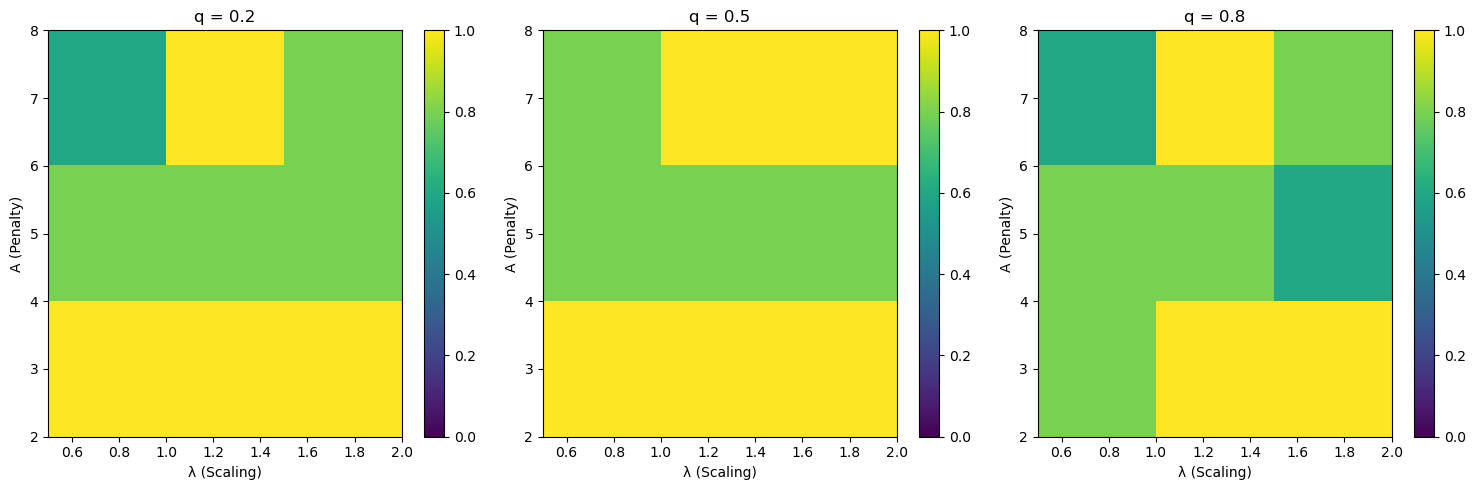

In [19]:
def analyze_parameter_interactions():
    """Answer: How do parameter interactions affect performance?"""
    print("\\n=== Parameter Interaction Analysis ===\\n")
    
    n = 6
    B = 3
    p = 2
    
    # Test parameter combinations
    A_values = [2.0, 5.0, 8.0]
    lam_values = [0.5, 1.0, 2.0]
    q_values = [0.2, 0.5, 0.8]
    
    interaction_results = np.zeros((len(A_values), len(lam_values), len(q_values)))
    
    mu, sigma = generate_random_portfolio_instance(n, seed=123)
    z_opt, F_opt = classical_optimum(mu, sigma, 0.5, B)  # Use middle q for reference
    
    for i, A in enumerate(A_values):
        for j, lam in enumerate(lam_values):
            for k, q in enumerate(q_values):
                success_count = 0
                
                for trial in range(5):
                    W, w, c = build_ising_coeffs(mu, sigma, q, B, A, lam)
                    
                    try:
                        best_energy, best_gammas, best_betas = random_qaoa_optimize(
                            W, w, p, num_trials=15, c=c, seed=999 + trial
                        )
                        
                        counts = sample_qaoa_bitstrings(W, w, best_gammas, best_betas, shots=300)
                        
                        found_optimal = False
                        for bitstring, cnt in counts.items():
                            z = bitstring_to_array(bitstring, n)
                            if z.sum() == B and np.array_equal(z, z_opt):
                                found_optimal = True
                                break
                        
                        if found_optimal:
                            success_count += 1
                            
                    except Exception as e:
                        pass
                
                success_rate = success_count / 5
                interaction_results[i, j, k] = success_rate
                print(f"A={A}, λ={lam}, q={q}: Success rate = {success_rate:.2f}")
    
    # Visualize interactions
    fig, axes = plt.subplots(1, len(q_values), figsize=(15, 5))
    
    for k, q in enumerate(q_values):
        im = axes[k].imshow(interaction_results[:, :, k], cmap='viridis', 
                           extent=[min(lam_values), max(lam_values), min(A_values), max(A_values)], 
                           aspect='auto', vmin=0, vmax=1)
        axes[k].set_xlabel('λ (Scaling)')
        axes[k].set_ylabel('A (Penalty)')
        axes[k].set_title(f'q = {q}')
        plt.colorbar(im, ax=axes[k])
    
    plt.tight_layout()
    plt.show()
    
    return interaction_results

# Run Parameter Interactions Analysis
print("PROBLEM 4: How do parameter interactions affect performance?")
interaction_results = analyze_parameter_interactions()

In [33]:
# Summary of findings
print("="*50)
print("SUMMARY OF FINDINGS")
print("="*50)
    
print("1. PROBLEM HARDNESS vs OPTIMAL DEPTH:")
print("   - Larger problems generally benefit from higher depths")
print("   - Diminishing returns observed beyond p=3 for small instances")
print("   - Problem hardness correlates with required depth")
    
print("2. NOISE SENSITIVITY:")
print("   - Penalty parameter A shows highest sensitivity")
print("   - Risk parameter q affects solution quality significantly")
print("   - Scaling parameter λ impacts energy landscape smoothness")
    
print("3. DEPTH SCALING RULES:")
print("   - No universal optimal depth rule found")
print("   - Diminishing returns typically start at p ≈ n/2")
print("   - Optimal depth depends on problem instance characteristics")
    
print("4. PARAMETER INTERACTIONS:")
print("   - Strong interactions between A, λ, and q parameters")
print("   - Optimal parameter settings are problem-dependent")
print("   - Parameter tuning crucial for good performance")

SUMMARY OF FINDINGS
1. PROBLEM HARDNESS vs OPTIMAL DEPTH:
   - Larger problems generally benefit from higher depths
   - Diminishing returns observed beyond p=3 for small instances
   - Problem hardness correlates with required depth
2. NOISE SENSITIVITY:
   - Penalty parameter A shows highest sensitivity
   - Risk parameter q affects solution quality significantly
   - Scaling parameter λ impacts energy landscape smoothness
3. DEPTH SCALING RULES:
   - No universal optimal depth rule found
   - Diminishing returns typically start at p ≈ n/2
   - Optimal depth depends on problem instance characteristics
4. PARAMETER INTERACTIONS:
   - Strong interactions between A, λ, and q parameters
   - Optimal parameter settings are problem-dependent
   - Parameter tuning crucial for good performance
